**Cohortes Avanzados**

In [ ]:
#%run './EDA.ipynb'
#%run './analisis-calidad-datos-y-outliers.ipynb'

%run 'EDA.jpynb'
%run 'analisis-calidad-datos-y-outliers.jpynb'

**1. Estacionalidad:**
- Cohorte Mensual: Análisis mensual de volúmenes de compra por región para identificar patrones estacionales.
- Comparación Año a Año: Comparar volúmenes y precios promedio año a año para identificar temporadas de alta demanda.
- Días Festivos y Temporadas de Vacaciones: Crear cohortes basados en semanas festivas y periodos de vacaciones para analizar cambios en compras.

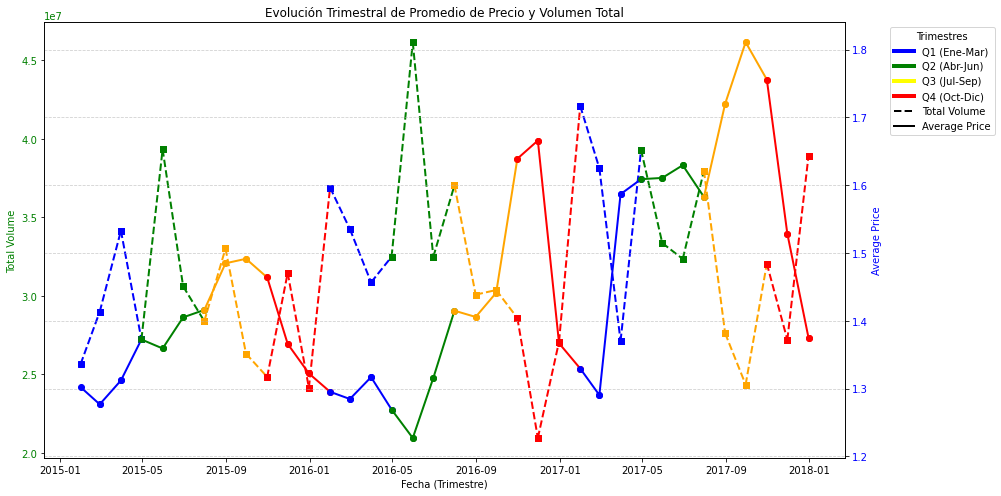

In [ ]:
#1.1 Volumenes de compra por región y detección de patrones estacionales

# Filtrar el DataFrame extendido para incluir solo fechas hasta diciembre de 2017
df_avocado_hotels = df_avocado_hotels[df_avocado_hotels['Date'] < '2018-01-01']

# Asignar colores según el trimestre
quarter_colors = {
    1: 'blue',   # Q1
    2: 'green',  # Q2
    3: 'orange', # Q3
    4: 'red'   # Q4
}

# Obtener colores para cada trimestre
cor1['Color'] = cor1['Date'].dt.quarter.map(quarter_colors)

# Crear la visualización
fig, ax1 = plt.subplots(figsize=(14, 7))

# Gráfico de líneas para el volumen total con colores por trimestre
for i in range(len(cor1)):
    ax1.plot(cor1['Date'].iloc[i:i+2], cor1['total_volume'].iloc[i:i+2],
             marker='s', linestyle='--', linewidth=2, color=cor1['Color'].iloc[i])
ax1.set_xlabel('Fecha (Trimestre)')
ax1.set_ylabel('Total Volume', color='green')
ax1.tick_params(axis='y', labelcolor='green')

# Crear un segundo eje y para el promedio de precio
ax2 = ax1.twinx()
for i in range(len(cor1)):
    ax2.plot(cor1['Date'].iloc[i:i+2], cor1['avg_price'].iloc[i:i+2],
             marker='o', linestyle='-', linewidth=2, color=cor1['Color'].iloc[i])
ax2.set_ylabel('Average Price', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

# Añadir leyenda para los colores
quarter_labels = [
    plt.Line2D([0], [0], color='blue', lw=4, label='Q1 (Ene-Mar)'),
    plt.Line2D([0], [0], color='green', lw=4, label='Q2 (Abr-Jun)'),
    plt.Line2D([0], [0], color='yellow', lw=4, label='Q3 (Jul-Sep)'),
    plt.Line2D([0], [0], color='red', lw=4, label='Q4 (Oct-Dic)'),
    plt.Line2D([0], [0], color='black', lw=2, linestyle='--', label='Total Volume'),
    plt.Line2D([0], [0], color='black', lw=2, linestyle='-', label='Average Price')
]

ax1.legend(handles=quarter_labels, loc='upper left', bbox_to_anchor=(1.05, 1), title="Trimestres")



plt.title('Evolución Trimestral de Promedio de Precio y Volumen Total')
fig.tight_layout()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

Se puede observar que cuando los precios han sido más bajos se han aprovechado a adquirir mayores volúmenes de compra. Se observan picos de compra en primavera, especialmente en mayo, previo a el verano.

También se puede observar que en aquellos picos donde el precio ha sido más alto, la compra ha disminuído, y cuando la compra se ha situado por debajo del precio, como en el caso de Q4-2016 y Q1-2017, correspondiente al SuperBowld de ese año, donde en el Q anterior se compraron bastantes aguacates, también relacionado con las festiviades y para Q1 disminuye considerablemente. 

Se oberva un pico en el consumo de aguacates en junio del 2016, puede hacer referencia a fechas cómo el 4 de Julio. 

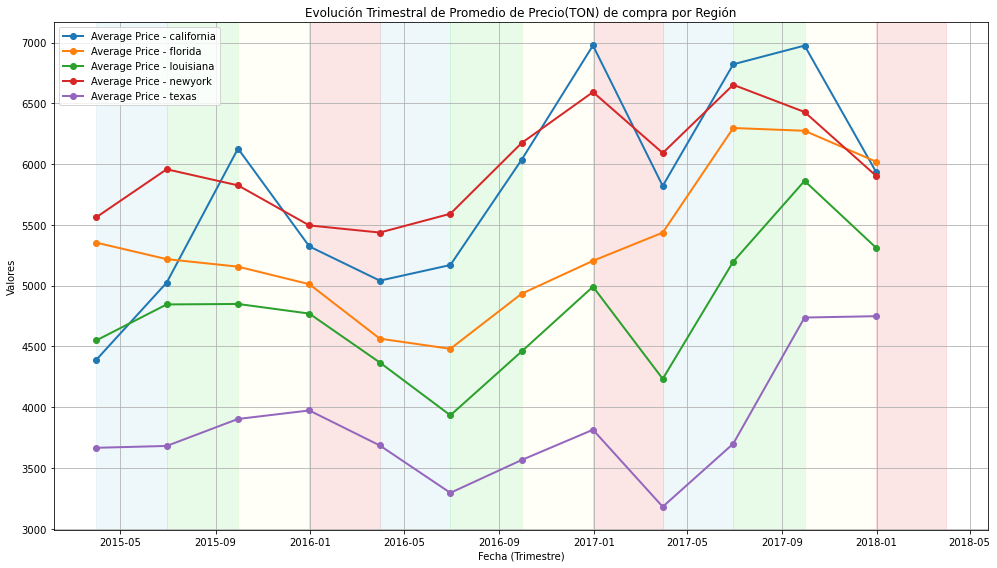

In [ ]:
# Agrupar los datos por location y trimestre y calcular el promedio de 'AveragePrice' y la suma de 'Total Volume' por toneladas
cor2 = df_avocado_hotels.groupby([pd.Grouper(key='Date', freq='Q'), 'location']).agg(
    avg_price=('precio_tonelada', 'mean'),
    total_volume=('Total Volume', 'sum')
).reset_index()


# Crear la visualización con fondo de colores por estación
plt.figure(figsize=(14, 8))

# Fondo de colores por trimestre
for i, date in enumerate(cor2['Date'].unique()):
    quarter = pd.Timestamp(date).quarter
    plt.axvspan(date, date + pd.DateOffset(months=3), color=quarter_colors[quarter], alpha=0.2)

# Gráfico de líneas para comparar las regiones
for region in cor2['location'].unique():
    region_data = cor2[cor2['location'] == region]
    plt.plot(region_data['Date'], region_data['avg_price'], marker='o', label=f'Average Price - {region}', linewidth=2)

plt.title('Evolución Trimestral de Promedio de Precio(TON) de compra por Región')
plt.xlabel('Fecha (Trimestre)')
plt.ylabel('Valores')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Fechas del Super Bowl:
--> 50	7 feb, 2016	Levi's Stadium	Santa Clara, California
--> LI	5 feb, 2017	Houston, Texas (3)

En el Super Bowl del 2017 se consumieron cerda de 200 millones de dólares en aguacates. Por eso se observa un aumento particular en el aumento del precio para otros estados, menos para Texas, entendiendo que por volumen se dió mejor precio a texas.

# **2. Exceso de Compras (Desperdicios o Fechas Especiales):**
- Compras Atípicas: Detectar semanas con volúmenes significativamente inferiores a 1T para reducir costos adicionales en transporte, por falta de planificación.
- Compras Atípicas: Detectar semanas con volúmenes significativamente superiores a la media para investigar posibles desperdicios.
- Eventos Especiales: Identificar picos de compras asociados con eventos conocidos o temporadas de promociones de hoteles.

In [ ]:
# 1. Cohortes avanzados: Agrupar por mes y región para exceso de compras
# Calcular estadísticas para detección de compras atípicas
volume_mean = df_avocado_hotels['Total Volume'].mean()
volume_std = df_avocado_hotels['Total Volume'].std()

# Identificar semanas con volúmenes superiores a la media + 2 desviaciones estándar
df_outliers = df_avocado_hotels[df_avocado_hotels['Total Volume'] > (volume_mean + 2 * volume_std)]

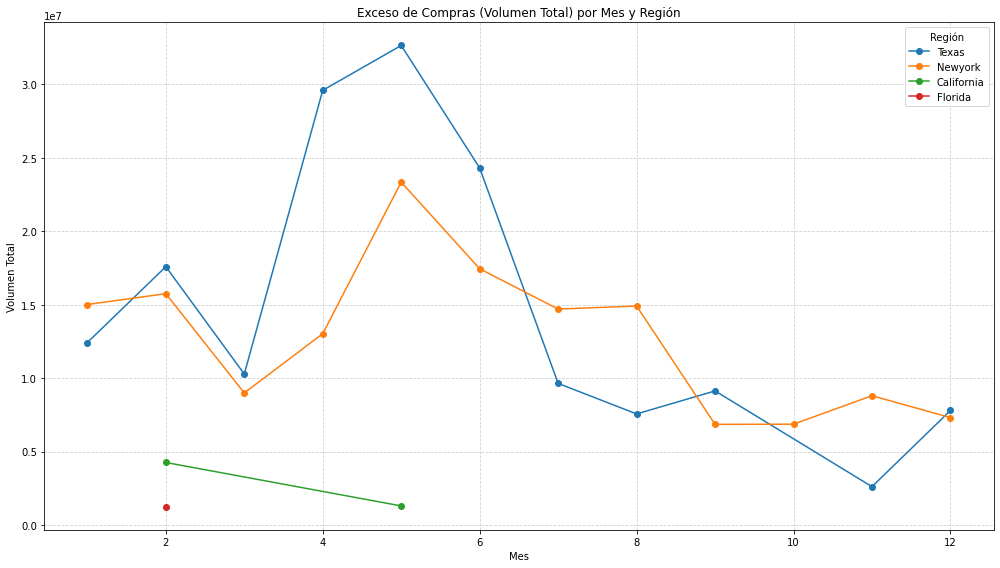

In [ ]:
df_outliers['Month'] = df_outliers['Date'].dt.month  # Extraer mes
cohorte_exceso = df_outliers.groupby(['Month', 'location', 'type']).agg(
    total_volume=('Total Volume', 'sum'),
    avg_price=('AveragePrice', 'mean'),
    count=('Total Volume', 'count')
).reset_index()

# Visualización
plt.figure(figsize=(14, 8))

# Diferenciar por región
for location in df_outliers['location'].unique():
    filtered = cohorte_exceso[cohorte_exceso['location'] == location]
    plt.plot(
        filtered['Month'], filtered['total_volume'], marker='o',
        label=location.capitalize()
    )

plt.title('Exceso de Compras (Volumen Total) por Mes y Región')
plt.xlabel('Mes')
plt.ylabel('Volumen Total')
plt.legend(title='Región')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

Observaciones del análisis de cohortes:
- Concentración de outliers: Los valores atípicos representan compras muy grandes de aguacates. Esto podría estar relacionado con eventos especiales, altas demandas estacionales o errores en los datos.
- Precios moderados: A pesar de los altos volúmenes, los precios son relativamente bajos, lo que podría indicar promociones o economías de escala.
Distribución temporal: Los años 2015-2017 parecen ser periodos clave para estas compras atípicas.

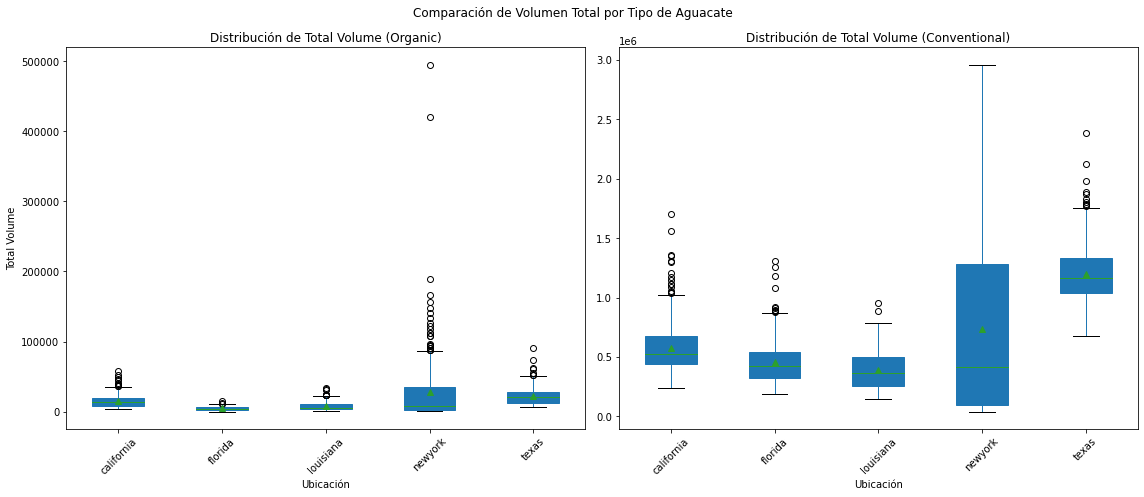

In [ ]:
# Crear dos boxplots separados por tipo de aguacate
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Filtrar datos por tipo de aguacate
for i, avocado_type in enumerate(['organic', 'conventional']):
    df_filtered = df_avocado_hotels[df_avocado_hotels['type'] == avocado_type]
    df_filtered.boxplot(column='Total Volume', by='location', grid=False, patch_artist=True,
                        showmeans=True, ax=axes[i])
    axes[i].set_title(f'Distribución de Total Volume ({avocado_type.capitalize()})')
    axes[i].set_xlabel('Ubicación')
    axes[i].set_ylabel('Total Volume' if i == 0 else '')
    axes[i].tick_params(axis='x', rotation=45)

# Personalización general
fig.suptitle('Comparación de Volumen Total por Tipo de Aguacate')
plt.tight_layout()
plt.show()

En la visualización anterior se observan la distribución del volumen total por cada tipo de aguacate y por cada ubicación, se observan que en el caso de NewYork se presentan outliers en aguacate orgánico. A continuación vamos a analizar para observar que pudo haber sucedido. En el caso de los aguacates convencionales observamos mayores diferencias en California y en Texas.

## Compras Atípicas más altas

In [ ]:
# Ordenar el DataFrame por 'Total Volume' en orden descendente y seleccionar los 30 más altos
top_10_peaks = df_avocado_hotels.nlargest(10, 'Total Volume')[['Date','type', 'Total Volume', 'location','cant_toneladas']]
# Redondear 'Total Volume' a 2 decimales
top_10_peaks['Total Volume'] = top_10_peaks['Total Volume'].round(2)

# Mostrar la tabla de los 30 picos más altos
print(top_10_peaks.sort_values(by='Date', ascending=True))


           Date          type  Total Volume location  cant_toneladas
1489 2015-05-10  conventional    2118593.92  newyork         2118.59
1466 2015-10-18  conventional    1856337.85  newyork         1856.34
1464 2015-11-01  conventional    2180520.22  newyork         2180.52
4313 2016-01-17  conventional    1840344.27  newyork         1840.34
4310 2016-02-07  conventional    2202127.86  newyork         2202.13
4309 2016-02-14  conventional    1806980.64  newyork         1806.98
4297 2016-05-08  conventional    2740587.86  newyork         2740.59
4294 2016-05-29  conventional    1827100.26  newyork         1827.10
6246 2017-02-05  conventional    1772501.55    texas         1772.50
7147 2017-02-05  conventional    2544483.08  newyork         2544.48
6617 2017-02-05  conventional    1977923.65    texas         1977.92
7146 2017-02-12  conventional    1955395.44  newyork         1955.40
6606 2017-04-23  conventional    1776220.69    texas         1776.22
6605 2017-04-30  conventional    1

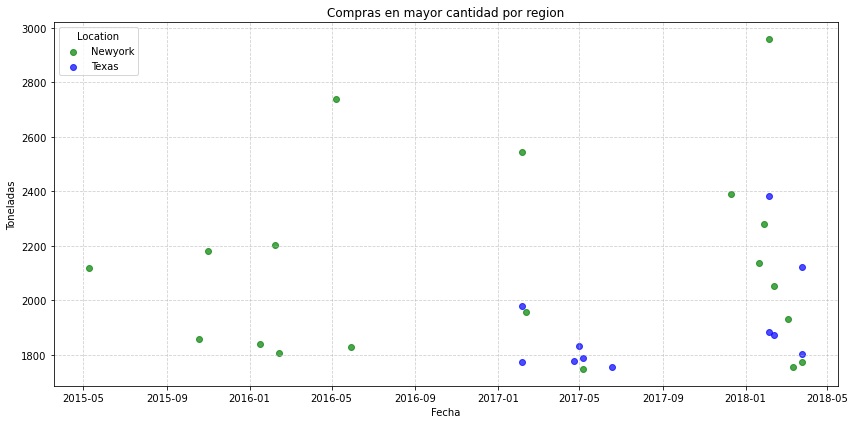

In [ ]:
# Crear un scatter plot sencillo para valores entre 0 y 1 tonelada
plt.figure(figsize=(12, 6))

# Diferenciar por tipo de aguacate (convencional y orgánico)
for place, color in zip(['newyork', 'texas'], ['green', 'blue']):
    filtered = top_10_peaks[top_10_peaks['location'] == place]
    plt.scatter(filtered['Date'], filtered['cant_toneladas'], label=place.capitalize(), color=color, alpha=0.7)

# Personalización del gráfico
plt.title('Compras en mayor cantidad por region')
plt.xlabel('Fecha')
plt.ylabel('Toneladas')
plt.legend(title='Location')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

A continuación podemos observar las compras más altas realizadas Newyork:
- En el caso de Newyork, se pueden observar compras seguidas en octubre 2015, estas coinciden con fechas de Halloween y la maraton de Newyork, que se celebra la primera semana de Noviembre, donde posiblemente la demanda iba a ser muy alta en los distintos hoteles.  
- Compras recurentes a inicios del 2016 con un total de 3 en el Q1, realizadas en febrero, en temporada de San Valentin. El siguiente pedido grande se produjo en mayo, casi 90 días después. Se observa que este patrón se repite en 2017 y 2018.
- En 2018 se realizan compras a durante marzo, este es un fenómeno tardío, no repetido en los periodos anteriores.
En el caso de Texas podemos observar:
- Las compras más grandes se realizan a partir del 2017, siendo en Q1 el 05 de febrero, se realizaron dos pedidos de +3749T
- Además en muy poco tiempo últimos días de abril y primeros días de mayo se realizaron 4 pedidos más en 2017 y en 2018, correspondiente a la celebración del Cinco de Mayo. 

In [ ]:
# Calcular los valores más altos de Total Volume para New York, diferenciando orgánico y convencional
top_high_volumes_newyork = df_newyork.groupby('type').apply(
    lambda x: x.nlargest(5, 'Total Volume')
).reset_index(drop=True)

# Agregar columna de precio total (Total Price = Total Volume * Average Price)
top_high_volumes_newyork['Total Price'] = top_high_volumes_newyork['Total Volume'] * top_high_volumes_newyork['AveragePrice']

# Mostrar los resultados
top_high_volumes_newyork[['Date', 'type', 'Total Volume', 'AveragePrice', 'Total Price','cant_toneladas']]

,Date,type,Total Volume,AveragePrice,Total Price,cant_toneladas
0,2018-02-04,conventional,2959541.38,1.28,3.788213e+06,2959.54
1,2016-05-08,conventional,2740587.86,0.77,2.110253e+06,2740.59
2,2017-02-05,conventional,2544483.08,1.24,3.155159e+06,2544.48
3,2017-12-10,conventional,2390308.58,1.14,2.724952e+06,2390.31
4,2018-01-28,conventional,2278728.69,1.20,2.734474e+06,2278.73
5,2018-02-18,organic,495083.69,1.36,6.733138e+05,495.08
6,2017-02-19,organic,420410.54,1.36,5.717583e+05,420.41
7,2018-03-18,organic,189434.04,1.70,3.220379e+05,189.43
8,2017-06-18,organic,166308.13,1.91,3.176485e+05,166.31
9,2017-04-30,organic,156250.72,1.90,2.968764e+05,156.25


Observamos que los valores más altos para Newyork coinciden con: 
- Enero y febrero del 2018, febrero y diciembre 2017, mayo 2016 para aguacate convencional, siendo los mayores aoutliers.
- Febrero, marzo y agosto del 2018, febrero, abril y junio para 2017 son los mayores para aguacate orgánico. 

In [ ]:
# Filtrar datos para Texas
df_texas = df_avocado_hotels[df_avocado_hotels['location'].str.contains('texas', case=False)]

# Calcular los valores más altos de Total Volume para Texas, diferenciando orgánico y convencional
top_high_volumes_texas = df_texas.groupby('type').apply(
    lambda x: x.nlargest(5, 'Total Volume')
).reset_index(drop=True)

# Agregar columna de precio total (Total Price = Total Volume * Average Price)
top_high_volumes_texas['Total Price'] = top_high_volumes_texas['Total Volume'] * top_high_volumes_texas['AveragePrice']

# Mostrar los resultados
top_high_volumes_texas[['Date', 'type', 'Total Volume', 'AveragePrice', 'cant_toneladas']]

,Date,type,Total Volume,AveragePrice,cant_toneladas
0,2018-02-04,conventional,2381742.59,0.56,2381.74
1,2018-03-25,conventional,2120511.03,0.56,2120.51
2,2017-02-05,conventional,1977923.65,0.55,1977.92
3,2018-02-04,conventional,1885401.44,0.67,1885.40
4,2018-02-11,conventional,1870874.72,0.58,1870.87
5,2016-08-14,organic,90500.74,0.86,90.50
6,2016-08-21,organic,74326.53,0.86,74.33
7,2017-03-26,organic,61552.96,0.90,61.55
8,2017-04-16,organic,60261.72,0.88,60.26
9,2017-06-11,organic,55725.32,1.02,55.73


Observamos que los valores más altos para Texas coinciden con: 
- Se observa que los precios son bastante inferiores, se puede tratar de la economía de escala y la proximidad a los proveedores, por lo tanto una reducción en los costes de transporte. 
- Otras observaciones ya se han podido explicar. 

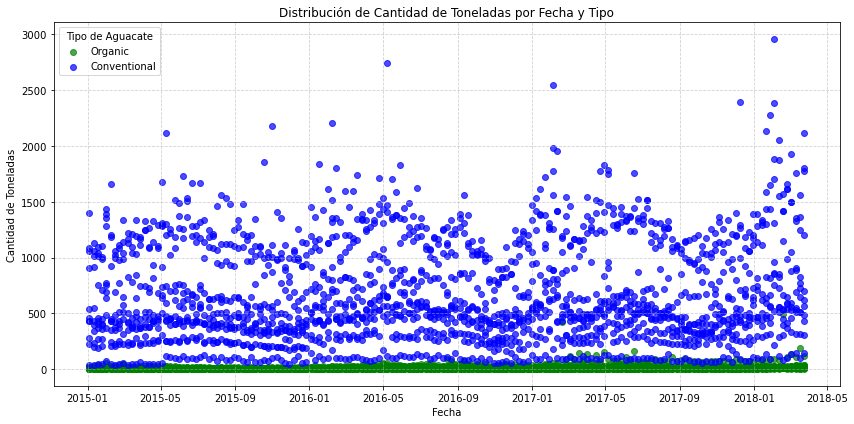

In [ ]:
# Crear un scatter plot para visualizar `cant_toneladas` a lo largo del tiempo, diferenciando por tipo
plt.figure(figsize=(12, 6))

# Diferenciar por tipo de aguacate (convencional y orgánico)
for avocado_type, color in zip(['organic', 'conventional'], ['green', 'blue']):
    filtered = df_avocado_hotels[df_avocado_hotels['type'] == avocado_type]
    plt.scatter(filtered['Date'], filtered['cant_toneladas'], label=avocado_type.capitalize(), color=color, alpha=0.7)

# Personalización del gráfico
plt.title('Distribución de Cantidad de Toneladas por Fecha y Tipo')
plt.xlabel('Fecha')
plt.ylabel('Cantidad de Toneladas')
plt.legend(title='Tipo de Aguacate')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [ ]:
# Crear un cohorte de frecuencia de compra para cada región
from datetime import timedelta

# Agrupar datos por región y ordenar por fecha
df_grouped_by_region = df_avocado_hotels.sort_values(by='Date').groupby('location')

# Calcular el tiempo entre compras y frecuencia
frecuencia_compras = df_grouped_by_region.apply(
    lambda x: pd.DataFrame({
        'location': x['location'],
        'Date': x['Date'],
        'Total Volume': x['Total Volume'],
        'Tiempo Entre Compras (días)': x['Date'].diff().dt.days
    })
).reset_index(drop=True)

# Eliminar registros con valores NaN en 'Tiempo Entre Compras (días)'
frecuencia_compras = frecuencia_compras.dropna(subset=['Tiempo Entre Compras (días)'])

# Calcular la frecuencia promedio para cada región
frecuencia_promedio = frecuencia_compras.groupby('location')['Tiempo Entre Compras (días)'].mean().reset_index()
frecuencia_promedio.columns = ['location', 'Promedio de Días Entre Compras']

# Visualizar la frecuencia promedio
frecuencia_promedio

,location,Promedio de Días Entre Compras
0,california,1.160908
1,florida,1.742222
2,louisiana,1.742222
3,newyork,1.742222
4,texas,1.742222


## Compras Atípicas menores a una tonelada

In [ ]:
# Verificar cuántos valores están entre 0 y 1
between_0_and_1 = df_avocado_hotels[(df_avocado_hotels['cant_toneladas'] > 0) & (df_avocado_hotels['cant_toneladas'] < 1)]

# Mostrar los resultados
between_0_and_1[['Date', 'AveragePrice', 'cant_toneladas', 'type', 'location']]

,Date,AveragePrice,cant_toneladas,type,location
9126,2015-12-27,1.83,0.99,organic,newyork
9130,2015-11-29,1.94,0.83,organic,newyork
9131,2015-11-22,1.94,0.86,organic,newyork
9136,2015-10-18,1.97,0.97,organic,newyork
9139,2015-09-27,1.98,0.81,organic,newyork
9140,2015-09-20,1.98,0.77,organic,newyork
9141,2015-09-13,1.99,0.90,organic,newyork
9161,2015-04-26,1.90,0.93,organic,newyork
10379,2015-11-22,1.11,0.66,organic,florida
10381,2015-11-08,1.59,0.08,organic,florida


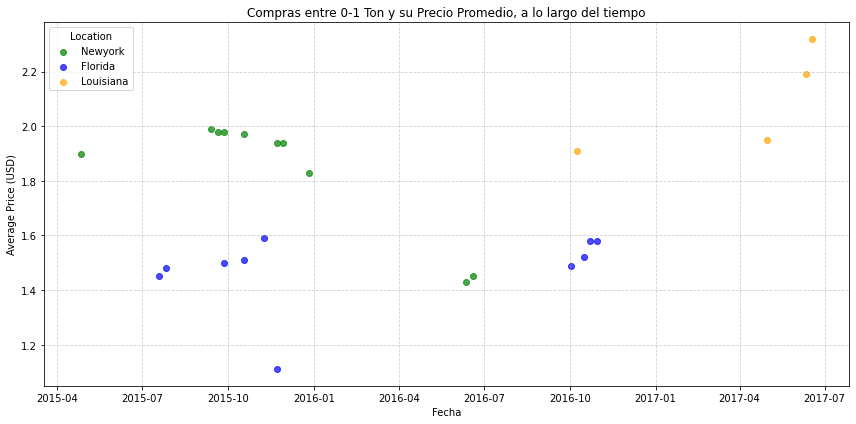

In [ ]:
# Crear un scatter plot sencillo para valores entre 0 y 1 tonelada
plt.figure(figsize=(12, 6))

# Diferenciar por tipo de aguacate (convencional y orgánico)
for place, color in zip(['newyork', 'florida','louisiana'], ['green', 'blue','orange']):
    filtered = between_0_and_1[between_0_and_1['location'] == place]
    plt.scatter(filtered['Date'], filtered['AveragePrice'], label=place.capitalize(), color=color, alpha=0.7)

# Personalización del gráfico
plt.title('Compras entre 0-1 Ton y su Precio Promedio, a lo largo del tiempo')
plt.xlabel('Fecha')
plt.ylabel('Average Price (USD)')
plt.legend(title='Location')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

- Aquí se puede observar la cantidad de compras de pedidos de aguacates menores a una tonelada, en total son 24 a lo largo del tiempo, destacando New York y Florida como los principales, esto provoca mayores costes cuanto más pedidos, se ha de pagar transporte, y demás costes asociados. Es por eso que una planeación adecuada puede ser la solución. 
- Podemos observar que todas las compras se deben a la compa de aguacate orgánico, para el caso de Florida este suceso ocurrio entre julio 2015 y diciembre 2015, y de nuevo se repitio en octubre 2016, con 4 pedidos <1 tonelada. Pagando un precio por encima de la media 1.39USD por unidad. 
- En el caso de las compras en Newyork estas se encuentran muy por encima de la media, superando +1.8USD, se agrupan estas compras en septiembre 2015 y finales del mismo año, y de nuevo en junio del 2016, obteniendo un mejor precio. 
- Por otro lado, Louisiana presenta las compras con el precio medio más alto >1.8USD, llegando a superar los 2USD, esto para compras de aguacates inferiores a 1T es asumir un coste mayor, además se observa que se trataron de pedidos a finales de Q2 2017.

### Cohortes basados en semanas festivas y vacaciones

In [10]:
# Crear una lista de eventos importantes y sus fechas
events = [
    {'event': 'Super Bowl', 'location': 'California', 'date': '2016-02-07'},
    {'event': 'Super Bowl', 'location': 'Texas', 'date': '2017-02-05'},
    {'event': 'Christmas', 'location': 'Newyork', 'date': '2015-12-25'},
    {'event': 'Christmas', 'location': 'Newyork', 'date': '2016-12-25'},
    {'event': 'Christmas', 'location': 'Newyork', 'date': '2017-12-25'},
    {'event': '5 de mayo', 'location': 'Texas', 'date': '2015-05-05'},
    {'event': '5 de mayo', 'location': 'Texas', 'date': '2016-05-05'},
    {'event': '5 de mayo', 'location': 'Texas', 'date': '2017-05-05'}
]

# Convertir la lista a un DataFrame
events = pd.DataFrame(events)

# Asegurarse de que la columna `date` sea de tipo datetime
events['date'] = pd.to_datetime(events['date'])

# Calcular `start_date` como 21 días antes de la fecha del evento
events['start_date'] = events['date'] - pd.Timedelta(days=21)

In [11]:
# Crear una lista para almacenar los resultados
filtered_data = []

# Iterar por cada evento en el dataset de eventos
for _, event in events.iterrows():
    # Filtrar las compras por rango de tiempo y región
    temp_df = df_avocado_hotels[
        (df_avocado_hotels['Date'] >= event['start_date']) & # Mayor a start_date
        (df_avocado_hotels['Date'] <= event['date']) & # Menor a fecha
        (df_avocado_hotels['location'].str.lower() == event['location'].lower())
    ]
    # Agregar una columna con el nombre del evento para identificar el cohorte
    temp_df = temp_df.copy()  # Evitar SettingWithCopyWarning
    temp_df['event'] = event['event']
    temp_df['start_date'] = event['start_date']

    # Almacenar el resultado
    filtered_data.append(temp_df)

# Combinar los resultados en un solo DataFrame
df_filtered = pd.concat(filtered_data, ignore_index=True)

# Crear una columna adicional para identificar el año de cada evento
df_filtered['event_year'] = df_filtered['event'] + " " + df_filtered['start_date'].dt.year.astype(str)

# Agrupar por cohorte (evento) y calcular las métricas agregadas
cohort_events = df_filtered.groupby('event_year').agg(
    total_volume=('Total Volume', 'sum'),              # Suma del volumen total
    Average_Price=('AveragePrice', 'mean'),            # Precio promedio
    total_transactions=('Total Volume', 'count'),      # Número total de transacciones
    total_ton=('cant_toneladas', 'sum'),               # Cantidad de toneladas
    start_date=('start_date', 'min'),                  # Fecha de inicio del cohorte
    end_date=('Date', 'max')                           # Fecha final del cohorte
).reset_index()

# Renombrar columnas para mayor claridad
cohort_events.rename(columns={
    'event_year': 'Event (Year)',
    'total_volume': 'Total Volume (Ton)',
    'Average_Price': 'Average Price (USD)',
    'total_transactions': 'Compras Totales',
    'total_ton': 'Toneladas',
    'start_date': 'Start Date',
    'end_date': 'End Date'
}, inplace=True)

# Calculo del porcentaje de crecimiento de año a año
# Extraer el nombre del evento y el año en columnas separadas
cohort_events[['Event', 'Year']] = cohort_events['Event (Year)'].str.rsplit(' ', n=1, expand=True)
cohort_events['Year'] = cohort_events['Year'].astype(int)

# Ordenar los datos por evento y año
cohort_growth = cohort_events.sort_values(by=['Event', 'Year'])

# Calcular el % de crecimiento año a año
cohort_events['Growth (%)'] = cohort_growth.groupby('Event')['Toneladas'].pct_change() * 100

# Mostrar los resultados
cohort_events.round(2)

,Event (Year),Total Volume (Ton),Average Price (USD),Compras Totales,Toneladas,Start Date,End Date,Event,Year,Growth (%)
0,5 de mayo 2015,6897810.63,1.05,12,6897.81,2015-04-14,2015-05-03,5 de mayo,2015,NaN
1,5 de mayo 2016,8388649.53,0.88,12,8388.66,2016-04-14,2016-05-01,5 de mayo,2016,21.61
2,5 de mayo 2017,9647062.37,0.96,12,9647.06,2017-04-14,2017-04-30,5 de mayo,2017,15.00
3,Christmas 2015,3785502.36,1.50,12,3785.51,2015-12-04,2015-12-20,Christmas,2015,NaN
4,Christmas 2016,4953878.37,1.72,16,4953.87,2016-12-04,2016-12-25,Christmas,2016,30.86
5,Christmas 2017,5286532.15,1.50,12,5286.53,2017-12-04,2017-12-24,Christmas,2017,6.72
6,Super Bowl 2016,8679945.14,1.34,24,8679.94,2016-01-17,2016-02-07,Super Bowl,2016,NaN
7,Super Bowl 2017,12040168.66,0.84,16,12040.17,2017-01-15,2017-02-05,Super Bowl,2017,38.71


/var/folders/5j/6t2j9zls237_klqhdt5ljdgr0000gn/T/ipykernel_77781/3053457357.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Event (Year)', y='Toneladas', data=cohort_events, palette='viridis')


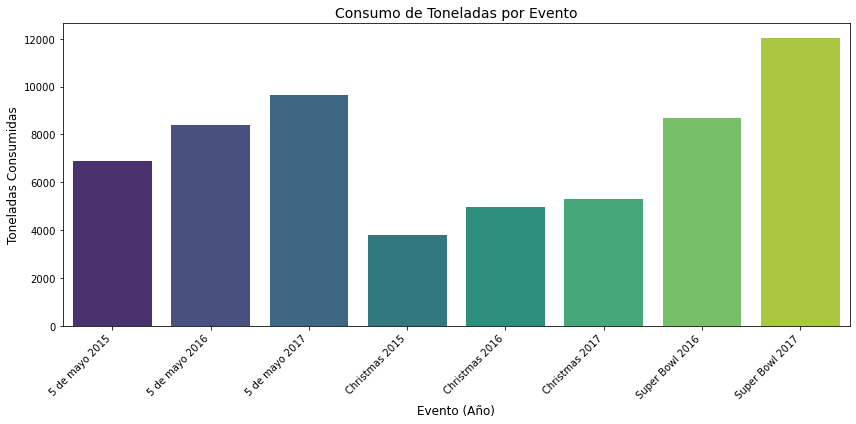

In [12]:
import seaborn as sns

# Crear un histograma para el consumo de toneladas por evento
plt.figure(figsize=(12, 6))
sns.barplot(x='Event (Year)', y='Toneladas', data=cohort_events, palette='viridis')
plt.xticks(rotation=45, ha='right')
plt.title('Consumo de Toneladas por Evento', fontsize=14)
plt.xlabel('Evento (Año)', fontsize=12)
plt.ylabel('Toneladas Consumidas', fontsize=12)
plt.tight_layout()
plt.show()

**3. Tipos de Aguacates (Orgánico vs. Convencional):**
- Segmentación por Tipo de Aguacate: Crear cohortes de compras separadas por type (orgánico vs. convencional) y analizar diferencias en precios y volúmenes por temporada.
- Demanda Relativa: Comparar la proporción de compras de orgánico vs. convencional a lo largo del año.

In [13]:
# 2- Rango de precios por location
price_range_by_location = df_avocado_hotels.groupby('location')['precio_tonelada'].agg(
    min_price='min',
    max_price='max',
    mean_price='mean'
).reset_index()

# Mostrar la tabla de rango de precios por ubicación
price_range_by_location.round(2)

,location,min_price,max_price,mean_price
0,california,2440.00,10833.94,5774.70
1,florida,2320.00,10158.12,5303.15
2,louisiana,2066.82,9165.03,4763.64
3,newyork,3080.00,8832.09,5939.55
4,texas,2040.00,6399.89,3834.45


In [14]:
# Recalcular métricas
type_metrics = df_filtered.groupby(['event', 'type']).agg(
    total_volume=('Total Volume', 'sum'),       # Suma del volumen total
    total_tons=('cant_toneladas', 'sum'),      # Suma de toneladas
    average_price=('AveragePrice', 'mean')     # Precio promedio
).reset_index()

# Calcular proporciones de demanda relativa (orgánico vs. convencional)
relative_demand = df_filtered.groupby(['event', 'type']).agg(
    total_volume=('Total Volume', 'sum')
).reset_index()

# Calcular el total por evento
total_volume_by_event = relative_demand.groupby('event')['total_volume'].transform('sum')

# Calcular la proporción
relative_demand['proportion (%)'] = (relative_demand['total_volume'] / total_volume_by_event) * 100

In [16]:
type_metrics

,event,type,total_volume,total_tons,average_price
0,5 de mayo,conventional,24536164.21,24536.15,0.755556
1,5 de mayo,organic,397358.32,397.38,1.168333
2,Christmas,conventional,13541215.63,13541.23,1.322500
3,Christmas,organic,484697.25,484.68,1.854000
4,Super Bowl,conventional,20322238.87,20322.23,0.846000
5,Super Bowl,organic,397874.93,397.88,1.437000


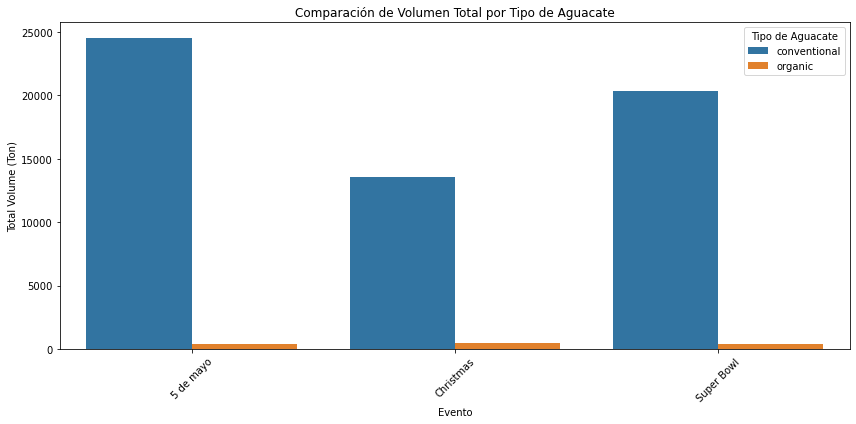

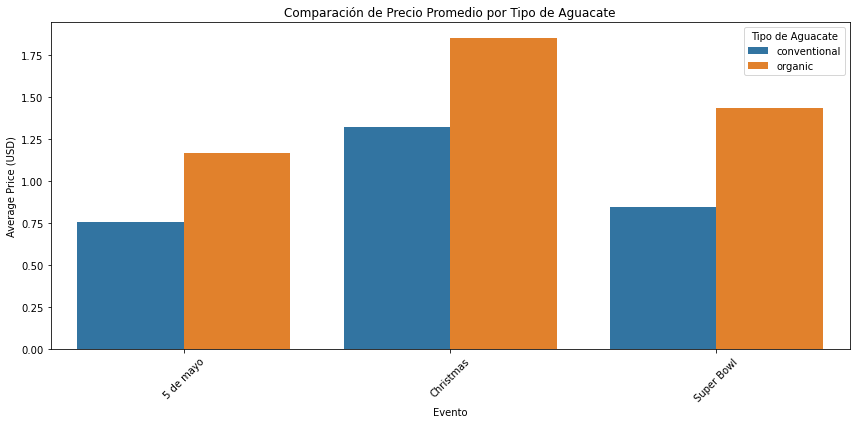

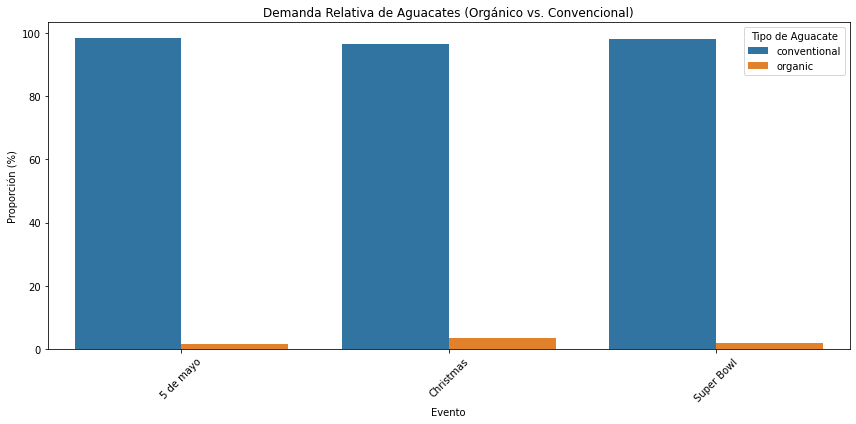

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Gráfico 1: Comparación de precios y volúmenes por tipo de aguacate (orgánico vs. convencional)
plt.figure(figsize=(12, 6))
sns.barplot(data=type_metrics, x="event", y="total_tons", hue="type")
plt.title("Comparación de Volumen Total por Tipo de Aguacate")
plt.xlabel("Evento")
plt.ylabel("Total Volume (Ton)")
plt.xticks(rotation=45)
plt.legend(title="Tipo de Aguacate")
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(data=type_metrics, x="event", y="average_price", hue="type")
plt.title("Comparación de Precio Promedio por Tipo de Aguacate")
plt.xlabel("Evento")
plt.ylabel("Average Price (USD)")
plt.xticks(rotation=45)
plt.legend(title="Tipo de Aguacate")
plt.tight_layout()
plt.show()

# Gráfico 2: Demanda relativa (proporción de orgánico vs. convencional) por evento
plt.figure(figsize=(12, 6))
sns.barplot(data=relative_demand, x="event", y="proportion (%)", hue="type")
plt.title("Demanda Relativa de Aguacates (Orgánico vs. Convencional)")
plt.xlabel("Evento")
plt.ylabel("Proporción (%)")
plt.xticks(rotation=45)
plt.legend(title="Tipo de Aguacate")
plt.tight_layout()
plt.show()

### Extra

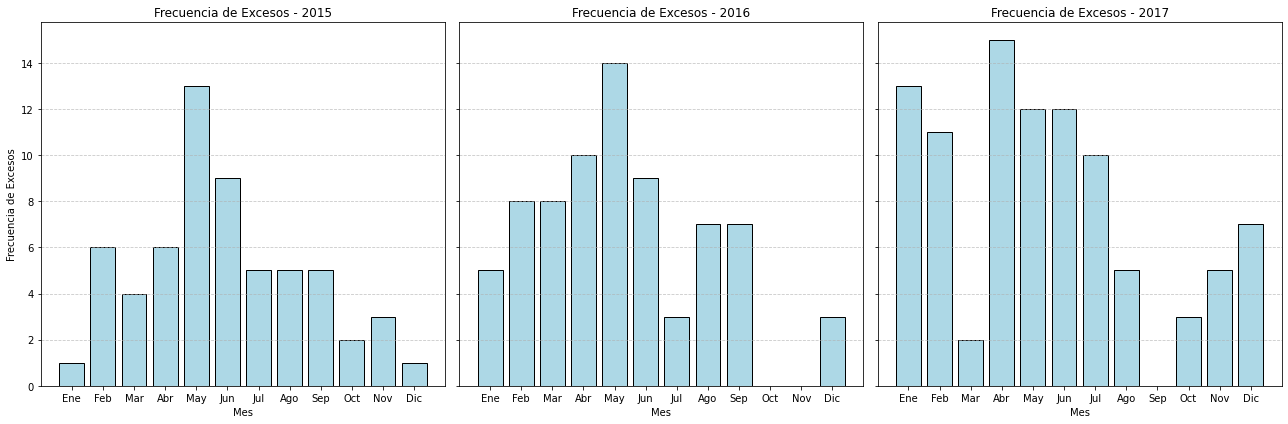

In [ ]:
# 1. Patrones temporales en los excesos

# Agrupar los datos de excesos por mes y año y calcular su frecuencia
excess_by_month_year = df_outliers.groupby([df_outliers['Date'].dt.year, 'Month']).size().reset_index(name='Frequency')

# Pivotar los datos para facilitar la visualización
excess_by_month_year_pivot = excess_by_month_year.pivot(index='Month', columns='Date', values='Frequency').fillna(0)

# Crear la visualización con 3 subgráficos
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Iterar por cada año y crear un subplot
years = sorted(df_outliers['Date'].dt.year.unique())
for i, year in enumerate(years):
    ax = axes[i]
    if year in excess_by_month_year_pivot.columns:
        ax.bar(excess_by_month_year_pivot.index, excess_by_month_year_pivot[year], color='lightblue', edgecolor='black')
        ax.set_title(f'Frecuencia de Excesos - {year}')
        ax.set_xlabel('Mes')
        ax.set_xticks(range(1, 13))
        ax.set_xticklabels(['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun', 'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic'])
    ax.grid(axis='y', linestyle='--', alpha=0.7)

axes[0].set_ylabel('Frecuencia de Excesos')
plt.tight_layout()
plt.show()